In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from os.path import join
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, mean_absolute_error as mae
import os
from pathlib2 import Path
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn import neural_network
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models, backend as K, callbacks


In [2]:
%run Utilities.ipynb

In [3]:
def create_sequence_data(df, win_length, train_test_split, valid_split):
    n_feature = df.shape[1]-1
    x_data, y_data = [], []
    
    for i in range(win_length, len(df)):
        x_data.append(df.iloc[i - win_length : i , 0:n_feature])
        y_data.append(df.iloc[i:i + 1 , n_feature])
    
    split_training_test_starting_point = int(round(train_test_split*len(x_data)))
    split_train_validation_starting_point = int(round(split_training_test_starting_point*(1-valid_split)))
    
    x_train = x_data[:split_train_validation_starting_point]
    y_train = y_data[:split_train_validation_starting_point]
    
    # if you want to choose the validation set by yourself, uncomment the below code.
    x_val = x_data[split_train_validation_starting_point:split_training_test_starting_point]
    y_val =  x_data[split_train_validation_starting_point:split_training_test_starting_point]                                             
    
    x_test = x_data[split_training_test_starting_point:]
    y_test = y_data[split_training_test_starting_point:]
    
    return np.array(x_train), np.array(x_test), np.array(x_val), np.array(y_train), np.array(y_test), np.array(y_val)

In [4]:
market_orders, n_markets, datasets = load_aggregated_datasets([DATASET_MSFT, 
                                                                          DATASET_NASDAQ, 
                                                                          DATASET_NYSE,
                                                                          DATASET_RUSSELL, 
                                                                          DATASET_SP])

# Load datasets
## DJI
dji_df = datasets["MSFT"]

## NASDAQ
nasdaq_df = datasets["NASDAQ"]

## NYSE
nyse_df = datasets["NYA"]

## Russell
russell_df = datasets["RUT"]

## SP
sp_df = datasets["S&P"]

In [5]:
list_df_one_feature = []

for df in [dji_df, nasdaq_df, nyse_df, russell_df, sp_df]:
    columns = df.columns
    df.fillna(0, inplace=True) # fill na with 0
    y = df["MOVEMENT"].copy()
    X = df.drop(columns=["MOVEMENT"]).copy()
    scaler = MinMaxScaler()
    X = pd.DataFrame(scaler.fit_transform(X))
    X["MOVEMENT"] = np.array(y)
    X.columns = columns
    list_df_one_feature.append(X)
    
### Clean dataframe
appl_df = list_df_one_feature[0]
nasdaq_df_full = list_df_one_feature[1]
nyse_df_full = list_df_one_feature[2]
russell_df_full = list_df_one_feature[3]
sp_df_full = list_df_one_feature[4]
appl_df

,Open,Close,Adj Close,Volume,Down-F,Sp500,Nasdaq,Russel,Gold,Silver,...,Macd,Macd_sig,Apo,Aroon_up,Aroon_down,Cci,Cmo,Dx,Ultosc,MOVEMENT
0,0.003808,0.003072,0.003072,0.234379,0.385932,0.363153,0.237896,0.237896,0.237896,0.502161,...,0.601530,0.593551,0.540930,0.714286,1.000000,0.668373,0.652669,0.482000,0.720594,0
1,0.001510,0.000473,0.000473,0.285715,0.382368,0.358684,0.234830,0.234830,0.234830,0.489132,...,0.599660,0.592643,0.540350,0.642857,0.928571,0.524770,0.520766,0.197818,0.608450,1
2,0.000500,0.000473,0.000473,0.211118,0.386561,0.362074,0.236675,0.236675,0.236675,0.490861,...,0.597849,0.591487,0.539169,0.571429,0.857143,0.482723,0.520766,0.175340,0.684523,1
3,0.002569,0.003821,0.003821,0.541920,0.387260,0.362382,0.236250,0.236250,0.236250,0.475939,...,0.599568,0.590970,0.537008,0.500000,1.000000,0.629057,0.625003,0.386009,0.712704,1
4,0.002452,0.006032,0.006032,0.663878,0.387505,0.363924,0.238975,0.238975,0.238975,0.475980,...,0.602857,0.591337,0.538785,0.428571,1.000000,0.657252,0.680640,0.489738,0.784756,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2311,0.867120,0.868998,0.868998,0.053976,0.997589,0.994683,0.991169,0.991169,0.991169,0.358204,...,0.604339,0.561745,0.537979,0.357143,0.928571,0.567800,0.514277,0.210579,0.574756,0
2312,0.870072,0.866984,0.866984,0.000000,0.996121,0.994221,0.991510,0.991510,0.991510,0.365491,...,0.608489,0.569293,0.544435,0.285714,0.857143,0.551154,0.491420,0.229867,0.599550,1
2313,0.873901,0.909264,0.909264,0.220364,1.000000,1.000000,1.000000,1.000000,1.000000,0.368311,...,0.655037,0.586375,0.573322,0.214286,1.000000,0.724620,0.740041,0.605819,0.850925,1
2314,0.917464,0.909812,0.909812,0.228156,0.999686,0.997843,0.997615,0.997615,0.997615,0.367384,...,0.691095,0.608596,0.607040,0.142857,1.000000,0.757840,0.742210,0.696802,0.654385,0


Optimal number of features:  7
     Feature  Ranking
48    Ultosc        1
30     Mom20        1
13   Usd_jpy        1
41  Macd_sig        1
39       Mfi        1
46       Cmo        1
45       Cci        1


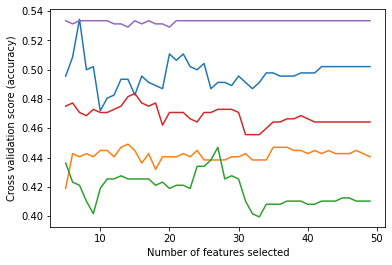

In [6]:
def feature_select(df, min):
    rfecv = RFECV(estimator=LogisticRegression(), step =1, min_features_to_select=min, cv=5, scoring='accuracy')
    y = df["MOVEMENT"].copy()
    X = df.drop(columns=["MOVEMENT"]).copy()
    selector = rfecv.fit(df.drop(columns=["MOVEMENT"]), df["MOVEMENT"])
    print("Optimal number of features: ", rfecv.n_features_)
    selected_rfe_features = pd.DataFrame({'Feature':list(X.columns), 'Ranking': selector.ranking_})
    selected_rfe_features.sort_values(by='Ranking',inplace=True)
    print(selected_rfe_features.head(rfecv.n_features_))
    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (accuracy)")
    plt.plot(range(min, len(rfecv.grid_scores_) + min), rfecv.grid_scores_)
    plt.show()
    reduced_X = pd.DataFrame(selector.transform(X))
    reduced_X["MOVEMENT"] = y
    return reduced_X

appl_df = feature_select(appl_df, 5)

In [7]:
list_df_pca = []
pca_config = [5, 4, 3, 2, 1]
def pca(df, n): 
    df.fillna(0, inplace=True) 
    pca = PCA(n_components=n)
    y = df["MOVEMENT"].copy()
    X = df.drop(columns=["MOVEMENT"]).copy()
    reduced_X = pd.DataFrame(pca.fit_transform(X))
    reduced_X["MOVEMENT"] = y
    return reduced_X

for i in pca_config:
    df = pca(appl_df, i)
    list_df_pca.append(df)
    

In [8]:
# Build sequential dataset with 60 days windown_length
X_train_list = []
X_test_list = []
y_test_list = []
y_train_list = []
for i in range(0, len(pca_config)):
    X_train, X_test, X_val, y_train, y_test, y_val = create_sequence_data(list_df_pca[i], win_length=60, train_test_split=0.9, valid_split = 0)
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

In [9]:
def create_model(neurons, win_length, num_features):
    model = tf.keras.Sequential()
    model.add(layers.GRU(neurons, input_shape=(win_length, num_features), return_sequences= False))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Dense(1, activation="tanh"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=20)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=20)
# file_path = 'best_model.h5'
# mc = tf.keras.callbacks.ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=2, save_best_only=True)
callbacks = [es]

In [10]:
grid_results = []
for i in range(0, len(pca_config)):
    param_grid ={
        "model__neurons": [2 , 8, 16, 32 ],
        "epochs": [100],
        "model__win_length": [60],
        "model__num_features": [pca_config[i]],
        "batch_size": [32, 64],
        "callbacks": callbacks,
        "validation_split": [0.1]
    }
    grid = GridSearchCV(estimator=model, param_grid=param_grid)
    grid_result = grid.fit(X_train_list[i], y_train_list[i], verbose=2)
    grid_results.append(grid_result)

Epoch 1/100
46/46 - 3s - loss: 4.0427 - accuracy: 0.4648 - val_loss: 3.4787 - val_accuracy: 0.4601 - 3s/epoch - 56ms/step
Epoch 2/100
46/46 - 0s - loss: 2.3859 - accuracy: 0.4648 - val_loss: 1.8025 - val_accuracy: 0.4601 - 494ms/epoch - 11ms/step
Epoch 3/100
46/46 - 1s - loss: 1.5658 - accuracy: 0.4648 - val_loss: 1.2113 - val_accuracy: 0.4601 - 506ms/epoch - 11ms/step
Epoch 4/100
46/46 - 1s - loss: 1.3078 - accuracy: 0.4648 - val_loss: 1.1604 - val_accuracy: 0.4601 - 502ms/epoch - 11ms/step
Epoch 5/100
46/46 - 1s - loss: 1.2085 - accuracy: 0.4648 - val_loss: 1.0993 - val_accuracy: 0.4601 - 571ms/epoch - 12ms/step
Epoch 6/100
46/46 - 1s - loss: 1.1672 - accuracy: 0.4648 - val_loss: 1.0656 - val_accuracy: 0.4601 - 522ms/epoch - 11ms/step
Epoch 7/100
46/46 - 1s - loss: 1.1040 - accuracy: 0.4648 - val_loss: 1.0343 - val_accuracy: 0.4601 - 519ms/epoch - 11ms/step
Epoch 8/100
46/46 - 1s - loss: 1.0577 - accuracy: 0.4648 - val_loss: 1.0065 - val_accuracy: 0.4601 - 526ms/epoch - 11ms/step
Epo

In [11]:
for i in range(0, len(grid_results)):
    grid_result = grid_results[i]
    print("\nBest: %f using %s with PCA n component = %f" % (grid_result.best_score_, grid_result.best_params_, pca_config[i]))
    y_pred = grid_result.predict(X_test_list[i])
    print("Accuracy best model on Test set: %f" % (np.mean(y_pred==y_test_list[i])))


Best: 0.535468 using {'batch_size': 32, 'callbacks': <keras.callbacks.EarlyStopping object at 0x0000013FBC82BDC0>, 'epochs': 100, 'model__neurons': 8, 'model__num_features': 5, 'model__win_length': 60, 'validation_split': 0.1} with PCA n component = 5.000000
8/8 [==============================] - 0s 3ms/step
Accuracy best model on Test set: 0.539823

Best: 0.518227 using {'batch_size': 32, 'callbacks': <keras.callbacks.EarlyStopping object at 0x0000013FBC82BDC0>, 'epochs': 100, 'model__neurons': 8, 'model__num_features': 4, 'model__win_length': 60, 'validation_split': 0.1} with PCA n component = 4.000000
8/8 [==============================] - 0s 3ms/step
Accuracy best model on Test set: 0.504425

Best: 0.506897 using {'batch_size': 32, 'callbacks': <keras.callbacks.EarlyStopping object at 0x0000013FBC82BDC0>, 'epochs': 100, 'model__neurons': 16, 'model__num_features': 3, 'model__win_length': 60, 'validation_split': 0.1} with PCA n component = 3.000000
8/8 [============================

In [12]:

# Best: 0.511330 using {'batch_size': 32, 'callbacks': <keras.callbacks.EarlyStopping object at 0x0000028D176FB160>, 'epochs': 100, 'model__neurons': 16, 'model__num_features': 5, 'model__win_length': 60, 'validation_split': 0.1} with PCA n component = 5.000000
# 8/8 [==============================] - 0s 3ms/step
# Accuracy best model on Test set: 0.469027

# Best: 0.506897 using {'batch_size': 32, 'callbacks': <keras.callbacks.EarlyStopping object at 0x0000028D176FB160>, 'epochs': 100, 'model__neurons': 8, 'model__num_features': 4, 'model__win_length': 60, 'validation_split': 0.1} with PCA n component = 4.000000
# 8/8 [==============================] - 0s 2ms/step
# Accuracy best model on Test set: 0.575221

# Best: 0.527094 using {'batch_size': 32, 'callbacks': <keras.callbacks.EarlyStopping object at 0x0000028D176FB160>,
#  'epochs': 100, 'model__neurons': 8, 'model__num_features': 3, 'model__win_length': 60, 'validation_split': 0.1} with PCA n component = 3.000000
# 8/8 [==============================] - 0s 2ms/step
# Accuracy best model on Test set: 0.579646

# Best: 0.525123 using {'batch_size': 32, 'callbacks': <keras.callbacks.EarlyStopping object at 0x0000028D176FB160>,
#  'epochs': 100, 'model__neurons': 16, 'model__num_features': 2, 'model__win_length': 60, 'validation_split': 0.1} with PCA n component = 2.000000
# 8/8 [==============================] - 0s 3ms/step
# Accuracy best model on Test set: 0.548673

# Best: 0.514778 using {'batch_size': 32, 'callbacks': <keras.callbacks.EarlyStopping object at 0x0000028D176FB160>, 'epochs': 100, 'model__neurons': 8, 'model__num_features': 1, 'model__win_length': 60, 'validation_split': 0.1} with PCA n component = 1.000000
# 8/8 [==============================] - 0s 2ms/step
# Accuracy best model on Test set: 0.570796

#gru


# Best: 0.506404 using {'batch_size': 32, 'callbacks': <keras.callbacks.EarlyStopping object at 0x000001FF4862B760>, 'epochs': 100, 'model__neurons': 32, 'model__num_features': 5, 'model__win_length': 60, 'validation_split': 0.1} with PCA n component = 5.000000
# 8/8 [==============================] - 0s 3ms/step
# Accuracy best model on Test set: 0.566372

# Best: 0.527094 using {'batch_size': 32, 'callbacks': <keras.callbacks.EarlyStopping object at 0x000001FF4862B760>,
#  'epochs': 100, 'model__neurons': 2, 'model__num_features': 4, 'model__win_length': 60, 'validation_split': 0.1} with PCA n component = 4.000000
# 8/8 [==============================] - 0s 2ms/step
# Accuracy best model on Test set: 0.570796

# Best: 0.526108 using {'batch_size': 32, 'callbacks': <keras.callbacks.EarlyStopping object at 0x000001FF4862B760>, 
# 'epochs': 100, 'model__neurons': 32, 'model__num_features': 3, 'model__win_length': 60, 'validation_split': 0.1} with PCA n component = 3.000000
# 8/8 [==============================] - 0s 3ms/step
# Accuracy best model on Test set: 0.415929

# Best: 0.518719 using {'batch_size': 64, 'callbacks': <keras.callbacks.EarlyStopping object at 0x000001FF4862B760>, 'epochs': 100, 'model__neurons': 32, 'model__num_features': 2, 'model__win_length': 60, 'validation_split': 0.1} with PCA n component = 2.000000
# 4/4 [==============================] - 0s 4ms/step
# Accuracy best model on Test set: 0.557522

# Best: 0.509852 using {'batch_size': 64, 'callbacks': <keras.callbacks.EarlyStopping object at 0x000001FF4862B760>, 'epochs': 100, 'model__neurons': 32, 'model__num_features': 1, 'model__win_length': 60, 'validation_split': 0.1} with PCA n component = 1.000000
# 4/4 [==============================] - 0s 4ms/step
# Accuracy best model on Test set: 0.570796

In [13]:
# Best: 0.508374 using {'batch_size': 32, 'callbacks': <keras.callbacks.EarlyStopping object at 0x0000026C91C43040>, 'epochs': 100, 'model__neurons': 8, 'model__num_features': 5, 'model__win_length': 60, 'validation_split': 0.1} with PCA n component = 5.000000
# 8/8 [==============================] - 1s 4ms/step
# Accuracy best model on Test set: 0.606195

# Best: 0.510345 using {'batch_size': 32, 'callbacks': <keras.callbacks.EarlyStopping object at 0x0000026C91C43040>, 'epochs': 100, 'model__neurons': 8, 'model__num_features': 4, 'model__win_length': 60, 'validation_split': 0.1} with PCA n component = 4.000000
# 8/8 [==============================] - 1s 4ms/step
# Accuracy best model on Test set: 0.610619

# Best: 0.514286 using {'batch_size': 64, 'callbacks': <keras.callbacks.EarlyStopping object at 0x0000026C91C43040>, 'epochs': 100, 'model__neurons': 8, 'model__num_features': 3, 'model__win_length': 60, 'validation_split': 0.1} with PCA n component = 3.000000
# 4/4 [==============================] - 1s 5ms/step
# Accuracy best model on Test set: 0.606195

# Best: 0.490148 using {'batch_size': 32, 'callbacks': <keras.callbacks.EarlyStopping object at 0x0000026C91C43040>, 'epochs': 100, 'model__neurons': 32, 'model__num_features': 2, 'model__win_length': 60, 'validation_split': 0.1} with PCA n component = 2.000000
# 8/8 [==============================] - 1s 9ms/step
# Accuracy best model on Test set: 0.469027

# Best: 0.524138 using {'batch_size': 64, 'callbacks': <keras.callbacks.EarlyStopping object at 0x0000026C91C43040>, 'epochs': 100, 'model__neurons': 8, 
# 'model__num_features': 1, 'model__win_length': 60, 'validation_split': 0.1} with PCA n component = 1.000000
# 4/4 [==============================] - 1s 5ms/step
# Accuracy best model on Test set: 0.606195

In [14]:
# Best: 0.522167 using {'batch_size': 64, 'callbacks': <keras.callbacks.EarlyStopping object at 0x0000014D57C53250>, 'epochs': 100, 'model__neurons': 8, 'model__num_features': 5, 'model__win_length': 60, 'validation_split': 0.1} with PCA n component = 5.000000
# 4/4 [==============================] - 0s 4ms/step
# Accuracy best model on Test set: 0.535398

# Best: 0.518227 using {'batch_size': 64, 'callbacks': <keras.callbacks.EarlyStopping object at 0x0000014D57C53250>, 'epochs': 100, 'model__neurons': 8, 'model__num_features': 4, 'model__win_length': 60, 'validation_split': 0.1} with PCA n component = 4.000000
# 4/4 [==============================] - 0s 4ms/step
# Accuracy best model on Test set: 0.553097

# Best: 0.509360 using {'batch_size': 32, 'callbacks': <keras.callbacks.EarlyStopping object at 0x0000014D57C53250>, 
# 'epochs': 100, 'model__neurons': 8, 'model__num_features': 3, 'model__win_length': 60, 'validation_split': 0.1} with PCA n component = 3.000000
# 8/8 [==============================] - 0s 3ms/step
# Accuracy best model on Test set: 0.530973

# Best: 0.517734 using {'batch_size': 32, 'callbacks': <keras.callbacks.EarlyStopping object at 0x0000014D57C53250>, 'epochs': 100, 'model__neurons': 32, 'model__num_features': 2, 'model__win_length': 60, 'validation_split': 0.1} with PCA n component = 2.000000
# 8/8 [==============================] - 0s 5ms/step
# Accuracy best model on Test set: 0.548673

# Best: 0.514286 using {'batch_size': 32, 'callbacks': <keras.callbacks.EarlyStopping object at 0x0000014D57C53250>, 'epochs': 100, 'model__neurons': 32, 'model__num_features': 1, 'model__win_length': 60, 'validation_split': 0.1} with PCA n component = 1.000000
# 8/8 [==============================] - 0s 5ms/step
# Accuracy best model on Test set: 0.530973

# AMZN

# Best: 0.535468 using {'batch_size': 32, 'callbacks': <keras.callbacks.EarlyStopping object at 0x0000013FBC82BDC0>, 'epochs': 100, 'model__neurons': 8, 'model__num_features': 5, 'model__win_length': 60, 'validation_split': 0.1} with PCA n component = 5.000000
# 8/8 [==============================] - 0s 3ms/step
# Accuracy best model on Test set: 0.539823

# Best: 0.518227 using {'batch_size': 32, 'callbacks': <keras.callbacks.EarlyStopping object at 0x0000013FBC82BDC0>, 'epochs': 100, 'model__neurons': 8, 'model__num_features': 4, 'model__win_length': 60, 'validation_split': 0.1} with PCA n component = 4.000000
# 8/8 [==============================] - 0s 3ms/step
# Accuracy best model on Test set: 0.504425

# Best: 0.506897 using {'batch_size': 32, 'callbacks': <keras.callbacks.EarlyStopping object at 0x0000013FBC82BDC0>, 'epochs': 100, 'model__neurons': 16, 'model__num_features': 3, 'model__win_length': 60, 'validation_split': 0.1} with PCA n component = 3.000000
# 8/8 [==============================] - 0s 3ms/step
# Accuracy best model on Test set: 0.526549

# Best: 0.518719 using {'batch_size': 32, 'callbacks': <keras.callbacks.EarlyStopping object at 0x0000013FBC82BDC0>, 'epochs': 100, 'model__neurons': 2, 'model__num_features': 2, 'model__win_length': 60, 'validation_split': 0.1} with PCA n component = 2.000000
# 8/8 [==============================] - 0s 2ms/step
# Accuracy best model on Test set: 0.522124

# Best: 0.521182 using {'batch_size': 64, 'callbacks': <keras.callbacks.EarlyStopping object at 0x0000013FBC82BDC0>, 'epochs': 100, 'model__neurons': 8, 'model__num_features': 1, 'model__win_length': 60, 'validation_split': 0.1} with PCA n component = 1.000000
# 4/4 [==============================] - 0s 3ms/step
# Accuracy best model on Test set: 0.526549